### Team Members:

* Swaroop Bhandary K
* Deepansh Pandey

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from torch.utils.data.sampler import SubsetRandomSampler

np.random.seed(1)
torch.manual_seed(1)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(1)

In [2]:
class LogisticRegressionModel(nn.Module):
    
    def __init__(self, layers):
        '''
        inputs:                        
            no_of_neurons_per_layer: an array defining the number of neurons in each layer
                                     including input layer.
                                     
        description:
            creates a network as defined by the variables. Applies relu activation after each
            layer and uses softmax in the final layer. 
                                    
        '''
        
        super(LogisticRegressionModel, self).__init__()
        self.layers = nn.ModuleList([nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()
        
    def forward(self, x):
        
        '''
        performs forward prop for the given input
        '''
       
        out = x 
        for layer in self.layers:
            out = self.relu(layer(out))          
        out = self.softmax(out)
        return out

In [3]:
# set device to cuda, if gpu is available

if torch.cuda.is_available():
    aDev = torch.device("cuda")
else:
    aDev = torch.device("cpu")  

# load the dataset    

train_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = dsets.CIFAR10(root='./data',
                            train=True,
                            transform=train_transforms,
                            download=True)

test_dataset = dsets.CIFAR10(root='./data',
                           train=False,
                           transform=transforms.ToTensor(),
                           download=True)    

CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### Using grid search to find the best hyperparameter

In [36]:
# fixed values 

input_dim = 32*32*3
output_dim = 10
num_epochs = 10 


# hyperparameters to tune
learning_rates = [0.001, 0.0005, 0.0001]
hidden_neurons = [100, 200, 300]
batch_sizes = [32, 64, 128]

accuracies = np.zeros([3,3,3])

for lr_id, lr_val in enumerate(learning_rates):
    for hn_id, hn_val in enumerate(hidden_neurons):
        for b_id, b_val in enumerate(batch_sizes):

            learning_rate = lr_val
            batch_size = b_val
            hidden_neuron = hn_val

            layers = np.array([input_dim, hidden_neuron, output_dim])

            criterion = nn.CrossEntropyLoss().to(aDev)

            model = LogisticRegressionModel(layers)
            model.to(aDev)
            
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

            # make the dataset iterable
            train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                       batch_size=batch_size,
                                                       shuffle=True)

            test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                                      batch_size=10000,
                                                      shuffle=False)

            for epoch in range(num_epochs):
                for i, (images, labels) in enumerate(train_loader):

                    images = images.view(-1, input_dim).to(aDev)
                    labels = labels.to(aDev)

                    optimizer.zero_grad()
                    outputs = model(images)

                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

            correct = 0
            total = 0

            for images, labels in test_loader:

                images = images.view(-1, input_dim).to(aDev) 
                outputs = model(images)

                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)         
                correct += (predicted.cpu() == labels.cpu()).sum().float()
            accuracy = 100. * correct / total

            accuracies[lr_id, hn_id, b_id] = accuracy
            print("learning rate: {0} hidden neuron: {1} batch: {2} accuracy: {3}".format(lr_val, hn_val, 
                                                                                          b_val, accuracy))
print("Grid search for hyperparameter tuning:")
print(accuracies)

learning rate: 0.001 hidden neuron: 100 batch: 32 accuracy: 31.950000762939453
learning rate: 0.001 hidden neuron: 100 batch: 64 accuracy: 26.56999969482422
learning rate: 0.001 hidden neuron: 100 batch: 128 accuracy: 22.809999465942383
learning rate: 0.001 hidden neuron: 200 batch: 32 accuracy: 25.780000686645508
learning rate: 0.001 hidden neuron: 200 batch: 64 accuracy: 20.81999969482422
learning rate: 0.001 hidden neuron: 200 batch: 128 accuracy: 29.940000534057617
learning rate: 0.001 hidden neuron: 300 batch: 32 accuracy: 14.890000343322754
learning rate: 0.001 hidden neuron: 300 batch: 64 accuracy: 25.700000762939453
learning rate: 0.001 hidden neuron: 300 batch: 128 accuracy: 30.5
learning rate: 0.0005 hidden neuron: 100 batch: 32 accuracy: 33.650001525878906
learning rate: 0.0005 hidden neuron: 100 batch: 64 accuracy: 26.229999542236328
learning rate: 0.0005 hidden neuron: 100 batch: 128 accuracy: 25.040000915527344
learning rate: 0.0005 hidden neuron: 200 batch: 32 accuracy: 

### We found that the best values for the hyperparameter values are as follows. We used grid search to get these values. 

* learning rate = 0.0005
* batch_size = 32
* hidden_neuron = 100

/home/swaroop/anaconda3/envs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


accuracy is 30.219999313354492
confusion matrix as shown below
[[771   0  49  72   7  40   7   2  51   1]
 [402  73  17 115  32 136   6   6 161  52]
 [198   0 368 197  35 165  13   3  18   3]
 [115   1  97 469  15 259  18   1  21   4]
 [173   0 250 189 164 172  23   8  19   2]
 [ 78   0 104 321  16 438  16   4  20   3]
 [ 44   0 150 331  49 258 151   0  15   2]
 [269   0 153 218  51 189  21  78  18   3]
 [412   2  27  64   5  67   3   0 415   5]
 [398  12  50 210   6  93  11   2 123  95]]


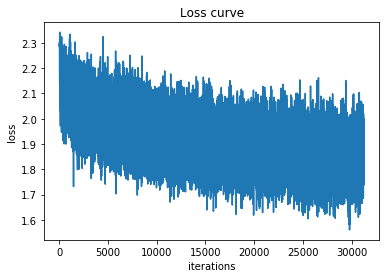

In [4]:
input_dim = 32*32*3
output_dim = 10

learning_rate = 0.0005
batch_size = 32
hidden_neuron = 100

layers = np.array([input_dim, hidden_neuron, output_dim])

criterion = nn.CrossEntropyLoss().to(aDev)

model = LogisticRegressionModel(layers)
model.to(aDev)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 20

# make the dataset iterable
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=10000,
                                          shuffle=False)
loss_list = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, input_dim).to(aDev)
        labels = labels.to(aDev)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
        loss.backward()
        optimizer.step()
        
correct = 0
total = 0

for images, labels in test_loader:
    images = images.view(-1, input_dim).to(aDev) 
    outputs = model(images)

    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)         
    correct += (predicted.cpu() == labels.cpu()).sum().float()

accuracy = 100. * correct / total
print("accuracy is {0}".format(accuracy))
print("confusion matrix as shown below")
print(confusion_matrix(labels.data.cpu().numpy(), predicted.data.cpu().numpy()))

plt.title("Loss curve")
plt.xlabel("iterations")
plt.ylabel("loss")
plt.plot(np.arange(len(loss_list)), loss_list)
plt.show()

### K-fold validation

In [23]:
def get_train_val_split(split_no, batch_size, k_fold=5):
    
    transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    train_dataset = dsets.CIFAR10(
        root='./data', train=True,
        download=True, transform=transform)

    valid_dataset = dsets.CIFAR10(
        root='./data', train=True,
        download=True, transform=transform)

    num_train = len(train_dataset)
    indices = list(range(num_train))
    
    # determines the number of samples in each splot
    split = int(np.floor(num_train/k_fold))

    # retains one part of the split for validation and the rest for training
    valid_idx = indices[split_no*split:(split_no+1)*split]  
    train_idx = np.array(list(filter(lambda x: x not in valid_idx, indices)))
        
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler)

    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler)

    return (train_loader, valid_loader)

In [24]:
input_dim = 32*32*3
output_dim = 10
batch_size = 64
num_epochs = 20

# define number of folds
kfolds = 5

# hyperparameters to tune
learning_rates = [0.001, 0.0005, 0.0001]
hidden_neurons = [100, 200, 300]


for learning_rate in learning_rates:
    for hidden_neuron in hidden_neurons:
        
        layers = np.array([input_dim, hidden_neuron, output_dim])
        criterion = nn.CrossEntropyLoss().to(aDev)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        model = LogisticRegressionModel(layers)
        model.to(aDev)

        for split_no in range(5):
            train_loader, val_loader = get_train_val_split(split_no, batch_size, kfolds)
            accuracy = 0

            for epoch in range(num_epochs):
                for i, (images, labels) in enumerate(train_loader):

                    images = images.view(-1, input_dim).to(aDev)
                    labels = labels.to(aDev)

                    optimizer.zero_grad()
                    outputs = model(images)

                    loss = criterion(outputs, labels)
                    loss_list.append(loss.item())
                    loss.backward()
                    optimizer.step()

            correct = 0
            total = 0

            for images, labels in val_loader:
                images = images.view(-1, input_dim).to(aDev) 
                outputs = model(images)

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)         
                correct += (predicted.cpu() == labels.cpu()).sum().float()

            accuracy += 100. * correct / total
        
        print("learning rate: {0} hidden neurons: {1} accuracy: {2}".format(learning_rate, hidden_neuron,
                                                                            accuracy/kfolds))

Files already downloaded and verified
Files already downloaded and verified


/home/swaroop/anaconda3/envs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
learning rate: 0.001 hidden neurons: 100 accuracy: 1.6040000915527344
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
learning rate: 0.001 hidden neurons: 200 accuracy: 1.4600000381469727
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded

As we can see from the accuracy values, there is an issue with the implementation of the kfold validation. We were not able to pin point the exact issue as we implemented it at the end and did not have enough time to debug it.

### Reference:

* https://gist.github.com/kevinzakka/d33bf8d6c7f06a9d8c76d97a7879f5cb